In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
import sys
sys.path.insert(1, 'scripts/')
from gen_matrix import matrix_gen, get_ICA
from get_sample import get_sample, create_strings_for_dataset
from fft import fft_for_sample
from tqdm import tqdm 
%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
import operator

In [4]:
def generate_simple_dataset(pandas=False):
    v = np.linspace(0, 200, 20000)
    
    dataset = v
    for i in range(h-1):
        dataset = np.vstack((dataset, v))
        
    if pandas:
        return pd.DataFrame(dataset)
    
    return dataset

def func_for_1class(t, noise=0.5):
    return 2*np.cos(5*pi*t) + 5*np.cos(15*pi*t) + 3*np.cos(20*pi*t) + noise

def func_for_2class(t, noise=0.5):
    return 2*np.cos(5*pi*t) + 2*np.cos(10*pi*t) + 3*np.cos(20*pi*t) + noise

def func_for_3class(t, noise=0.5):
    return 2*np.cos(5*pi*t) + 10*np.cos(20*pi*t) + 3*np.cos(20*pi*t) + noise

def get_cosinus_matrix():
    data_simple = generate_simple_dataset()
    vec = data_simple[65]
    
    size = (128, 20000)
    class_ = size[1]//3
    class1 = [0,class_]
    class2 = [class_,class_*2]
    class3 = [class_*2, data_simple.shape[1]]
    
    vec[class1[0]:class1[1]] = func_for_1class(vec[class1[0]:class1[1]])
    vec[class2[0]:class2[1]] = func_for_2class(vec[class2[0]:class2[1]])
    vec[class3[0]:class3[1]] = func_for_3class(vec[class3[0]:class3[1]])
    
    data_simple[65] = vec
    
    return data_simple

In [36]:
FIRST_N_FFT = 20
N_COMPONENTS_PCA = 60


data = get_cosinus_matrix()
ICA = get_ICA()
#Перемножаем ICA и EEG матрицы
matrix = np.matmul(ICA, data)
size = matrix.shape
class_ = class_ = size[1]//3

#Разбиваем на матрицы классов, чтоб проще было делить на семплы
matrix_class1 = matrix[:,0:class_]
matrix_calss2 = matrix[:, class_:class_*2]
matrix_calss3 = matrix[:, class_*2:data.shape[1]]
#Получаем семплы для каждого класса
sample_calss1 = get_sample(matrix_class1)
sample_calss2 = get_sample(matrix_calss2)
sample_calss3 = get_sample(matrix_calss3)
#Преобразование Фурье

samples_fft = list(map(abs, fft_for_sample(sample_calss1 + sample_calss2 + sample_calss3,
                                           first_n_elements=FIRST_N_FFT)))

len_class = len(sample_calss1)
sample_calss1_fft = samples_fft[:len_class]
sample_calss2_fft = samples_fft[len_class:len_class*2]
sample_calss3_fft = samples_fft[len_class*2:]

#Создание строк для датасета, из матрицы 128*20 -> в вектор 2560
sample_calss1_fft_str = create_strings_for_dataset(sample_calss1_fft)
sample_calss2_fft_str = create_strings_for_dataset(sample_calss2_fft)
sample_calss3_fft_str = create_strings_for_dataset(sample_calss3_fft)

#Создание таблицы объекты-признаки

#Класс 1
data_class_1 = pd.DataFrame(data=np.zeros((len_class, size[0] * FIRST_N_FFT)))
data_class_1['label'] = 1

for i in tqdm(range(len(sample_calss1_fft_str))):
    data_class_1.loc[i, :-1] = sample_calss1_fft_str[i]
    
    
#Класс 2
data_class_2 = pd.DataFrame(data=np.zeros((len_class, size[0] * FIRST_N_FFT)))
data_class_2['label'] = 2

for i in tqdm(range(len(sample_calss2_fft_str))):
    data_class_2.loc[i, :-1] = sample_calss2_fft_str[i]
    
    
#Класс 3
data_class_3 = pd.DataFrame(data=np.zeros((len_class, size[0] * FIRST_N_FFT)))
data_class_3['label'] = 3

for i in tqdm(range(len(sample_calss3_fft_str))):
    data_class_3.loc[i, :-1] = sample_calss3_fft_str[i]
    
    
data = pd.concat([data_class_1, data_class_2, data_class_3], axis=0)
print(data.shape)

100%|██████████| 34/34 [00:23<00:00,  1.47it/s]

(102, 2561)


In [37]:
N_COMPONENTS_PCA = 60

In [38]:
## Понизим размерность до 60 компонент
PCA = PCA(n_components=N_COMPONENTS_PCA)

#Стандартизируем матрицу
Scaler = StandardScaler()
data_standart = Scaler.fit_transform((data).iloc[:, :-1])
# Понижаем размерность
data_pca = PCA.fit_transform(data_standart)
data_pca = pd.DataFrame(data_pca)

# data_pca['label'] = data['label'].values
labels = data['label'].values

#Посмотрим важные признаки с помощью RF
rf = RandomForestClassifier()
rf.fit(data_pca, labels)

/Users/aleksandrbojko/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

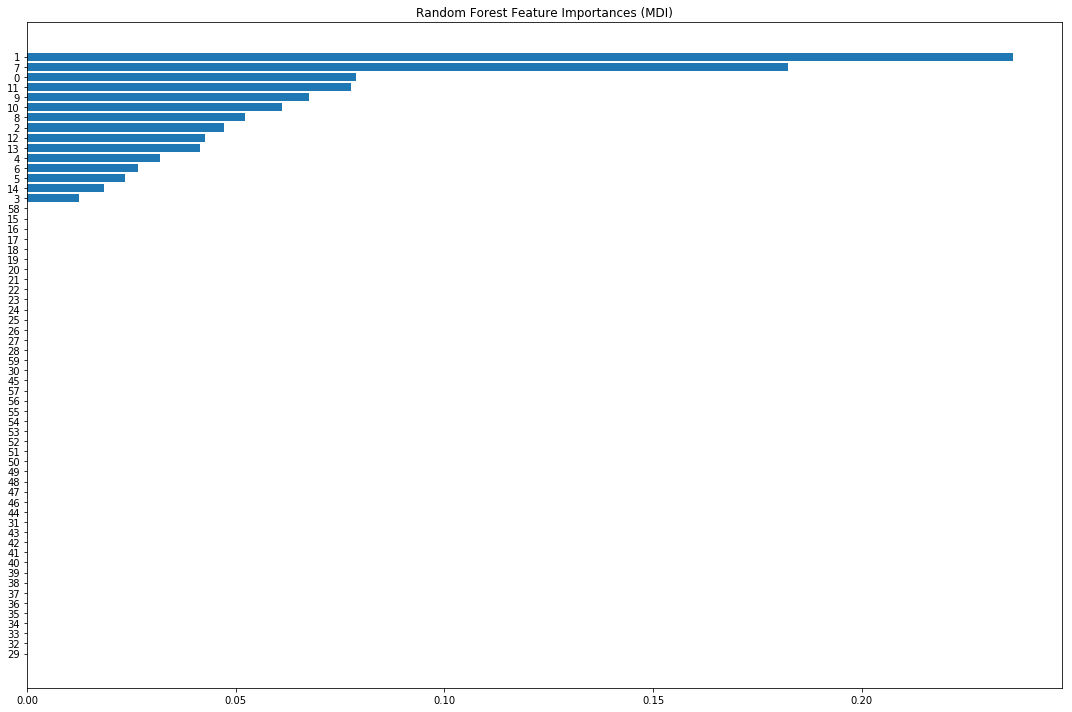

In [39]:
tree_feature_importances = (rf.feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(data_pca.columns))
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(data_pca.columns[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.savefig('RF PCA Feature Importances')
plt.show()

In [42]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = data_pca.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [72]:
def scoring_fi(feature_importances):
    above_zero = feature_importances['importance'][:np.sum(feature_importances['importance'] > 0)]
    mean_value = above_zero.mean()
    features_good = above_zero[above_zero > mean_value].index.tolist()
    features_normal = above_zero[above_zero <= mean_value].index.tolist()
    features_bad = [i for i in feature_importances.index.tolist() if i not in features_good and
                    i not in features_normal]
    
    return features_good, features_normal, features_bad

In [74]:
print(features_good)
print(features_normal)
print(features_bad)

[1, 7, 0, 11, 9]
[10, 8, 2, 12, 13, 4, 6, 5, 14, 3]
[48, 39, 40, 41, 42, 43, 44, 45, 46, 47, 55, 49, 50, 51, 52, 53, 54, 37, 56, 57, 58, 38, 30, 36, 35, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 59]


In [75]:
train_features = data_standart
from sklearn.decomposition import PCA
model = PCA(n_components=N_COMPONENTS_PCA).fit(train_features)
X_pc = model.transform(train_features)

features_good, features_normal, features_bad = scoring_fi(feature_importances)

In [76]:
def features_imp_pca(train_features, model_pca, X_pca, features_good, features_bad, features_normal):
    
    global size, N_COMPONENTS_PCA
    
    reward_best = 50
    reward_max = 10
    reward_med = 5
    reward_min = 1
    
    fe_imp = {}
    for feature in range(0, size[1]):
        fe_imp['feature' + '_' + str(feature)] = 0
        
    for feature in tqdm(range(0, size[1])):
        reward = 0
        for component in range(0, N_COMPONENTS_PCA):
            feature_value = model_pca.components_[component, feature]
            component_max = (pd.DataFrame(model_pca.components_).loc[component, :]).max()
            component_mean = (pd.DataFrame(model_pca.components_).loc[component, :]).mean()
            
            comparison_max = component_max - component_max / 10
            comparison_med = component_max - component_max / 20
            comparison_min = component_mean
            
            
            
            if feature_value >= comparison_min:
                if str(component) in features_bad:
                    reward -= reward_min
                elif str(feature) in features_good or str(feature) in features_normal:
                    reward += reward_min
            
            if feature_value >= comparison_med:
                if str(component) in features_bad:
                    reward -= reward_med
                elif str(component) in features_normal:
                    reward += reward_med
                elif str(component) in features_good:
                    reward += reward_max
            
            if feature_value >= comparison_max:
                if str(component) in features_bad:
                    reward -= reward_max
                elif str(component) in features_normal:
                    reward += reward_max
                elif str(component) in features_good:
                    reward += reward_best #best
                    
            if feature_value <= comparison_min:
                if str(component) in features_bad:
                    reward += reward_min
                elif str(component) in features_good or str(feature) in features_normal:
                    reward -= reward_min
                    
                    
        fe_imp['feature' + '_' + str(feature)] = reward
            
    return fe_imp
            
            
    
    
    

In [ ]:
d = features_imp_pca(train_features, model, X_pc, features_good, features_bad, features_normal)

 10%|█         | 2022/20000 [01:39<16:21, 18.31it/s]

In [364]:
sorted_d = sorted(d.items(), key=operator.itemgetter(1), reverse=True)
best_features = [sorted_d[i][0] for i in range(15)]

In [380]:
sorted_d[-15:]

[('feature_68', -14),
 ('feature_92', -14),
 ('feature_115', -14),
 ('feature_18', -15),
 ('feature_48', -15),
 ('feature_8', -16),
 ('feature_81', -16),
 ('feature_118', -16),
 ('feature_12', -18),
 ('feature_38', -18),
 ('feature_58', -18),
 ('feature_9', -20),
 ('feature_61', -20),
 ('feature_63', -20),
 ('feature_127', -20)]

In [362]:
with open('features_imp.txt', 'w') as fout:
    fout.write('name    weight')
    fout.write('\n')
    for i in sorted_d:
        fout.write(str(i[0]))
        fout.write(' ')
        fout.write(str(i[1]))
        fout.write('\n')

In [370]:
best_features

['feature_1110',
 'feature_598',
 'feature_651',
 'feature_854',
 'feature_779',
 'feature_553',
 'feature_982',
 'feature_802',
 'feature_674',
 'feature_809',
 'feature_681',
 'feature_930',
 'feature_726',
 'feature_937',
 'feature_470']

In [371]:
train_features

array([[-1.62481902, -1.62481933, -1.62481978, ...,  0.28294822,
         0.28289318,  0.28292233],
       [-1.59007362, -1.59007365, -1.59007369, ...,  0.28284189,
         0.28273783,  0.28279295],
       [-1.55532834, -1.55532807, -1.55532768, ...,  0.28291089,
         0.28283864,  0.28287691],
       ...,
       [ 1.24952989,  1.24952955,  1.24952908, ..., -1.02456085,
        -1.02427645, -1.02442708],
       [ 0.00925861,  0.00925807,  0.00925729, ..., -3.33192578,
        -3.33185263, -3.33189139],
       [-1.24365283, -1.24365299, -1.24365322, ..., -4.38443427,
        -4.38445104, -4.38444217]])

In [372]:
### Главные признаки, с которыми будем рабоать 
train_features = pd.DataFrame(train_features)
for number_feature in list(best_features):
    number_feature = int(number_feature.split('_')[1])
    train_features.iloc[:, number_feature] = train_features.iloc[:, number_feature].apply(lambda x: str(x) +
                                                                                          '_FE').values

# train_features.iloc[:, 1669] = train_features.iloc[:, 1669].apply(lambda x: str(x) + '_FE').values

In [373]:
### Восстановим исходный вид таблицы, а именно 128x20x100 (102 в данном примере)

old_table = []
for i in range(train_features.shape[0]):
    sample = pd.DataFrame(np.zeros((128, 20)))
    string = train_features.iloc[i, :]
    
    index_start = 0
    index_end = 128

        
    for s in range(20):
        sample.iloc[:, s] = string.iloc[index_start : index_end].values
        index_start = index_end
        index_end += 128

        if index_end > 2560:
            break

    old_table.append(sample.values)
  

In [374]:
### Найдем в исходной таблице важный признак

FE_items = []


for table_number, table in tqdm(enumerate(old_table)):
    for column in range(table.shape[1]):
        for idx in range(table.shape[0]):
            if len(str(table[idx, column]).split('_')) > 1:
                FE_items.append((table_number, idx, column))
            




0it [00:00, ?it/s]


39it [00:00, 389.02it/s]


78it [00:00, 387.30it/s]


102it [00:00, 384.83it/s]

In [384]:
with open('FE_items.txt', 'w') as fout:
    fout.write('номер семпла, индекс, колонка (грубо говоря, адрес важной цифры)')
    fout.write('\n')
    fout.write('В семпле X в Y колонке, на Z индексе, какой-то важный сигнал и так далее')
    fout.write('\n')
    for i in FE_items:
        fout.write(str(i))
        fout.write('\n')

In [375]:
(FE_items)

[(0, 86, 3),
 (0, 41, 4),
 (0, 86, 4),
 (0, 11, 5),
 (0, 34, 5),
 (0, 41, 5),
 (0, 86, 5),
 (0, 11, 6),
 (0, 34, 6),
 (0, 41, 6),
 (0, 86, 6),
 (0, 34, 7),
 (0, 41, 7),
 (0, 86, 7),
 (0, 86, 8),
 (1, 86, 3),
 (1, 41, 4),
 (1, 86, 4),
 (1, 11, 5),
 (1, 34, 5),
 (1, 41, 5),
 (1, 86, 5),
 (1, 11, 6),
 (1, 34, 6),
 (1, 41, 6),
 (1, 86, 6),
 (1, 34, 7),
 (1, 41, 7),
 (1, 86, 7),
 (1, 86, 8),
 (2, 86, 3),
 (2, 41, 4),
 (2, 86, 4),
 (2, 11, 5),
 (2, 34, 5),
 (2, 41, 5),
 (2, 86, 5),
 (2, 11, 6),
 (2, 34, 6),
 (2, 41, 6),
 (2, 86, 6),
 (2, 34, 7),
 (2, 41, 7),
 (2, 86, 7),
 (2, 86, 8),
 (3, 86, 3),
 (3, 41, 4),
 (3, 86, 4),
 (3, 11, 5),
 (3, 34, 5),
 (3, 41, 5),
 (3, 86, 5),
 (3, 11, 6),
 (3, 34, 6),
 (3, 41, 6),
 (3, 86, 6),
 (3, 34, 7),
 (3, 41, 7),
 (3, 86, 7),
 (3, 86, 8),
 (4, 86, 3),
 (4, 41, 4),
 (4, 86, 4),
 (4, 11, 5),
 (4, 34, 5),
 (4, 41, 5),
 (4, 86, 5),
 (4, 11, 6),
 (4, 34, 6),
 (4, 41, 6),
 (4, 86, 6),
 (4, 34, 7),
 (4, 41, 7),
 (4, 86, 7),
 (4, 86, 8),
 (5, 86, 3),
 (5, 41, 4),